## Code Documentation for Emotion Prediction Model Using CNN and CK+ Dataset

**CK+ (Extended Cohn-Kanade) Dataset** is an extensively used facial expression dataset that includes sequences of facial expressions starting from a neutral expression to a peak expression. It contains 327 sequences across 118 subjects. The advantage of using the **CK+ Dataset** comes from the high-resolution images and sequences that show the progression of expressions which is going to be useful for training dynamic expression recognition models. 

[Link to the dataset](https://www.kaggle.com/datasets/shuvoalok/ck-dataset)

[Code Citation](https://www.kaggle.com/code/shuvoalok/ck-using-cnn)

In [33]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

### Define transformation

In [34]:
# define the image size
img_size = 48 # 48x48 pixels to match the FER2013 dataset

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#### Load the dataset

In [35]:
# define the path to the dataset
train_dir = 'CK+'

# load the dataset
dataset = datasets.ImageFolder(root = train_dir, transform = transform)

#### Split datset into training and validation sets

In [36]:
train_size = int(0.7 * len(dataset))
validation_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - validation_size
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# labels mapping
emotion_labels = {0: "anger", 
                  1: "contempt", 
                  2: "disgust", 
                  3: "fear", 
                  4: "happy", 
                  5: "sadness", 
                  6: "surprise"}

#### Visualize sample images

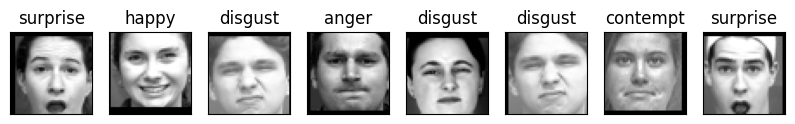

In [37]:
# function to display images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap = 'gray')
    
detaiter = iter(train_loader)
images, labels = next(detaiter)

# display images with their labels
fig = plt.figure(figsize = (10, 4))

# display first 8 images and their labels
for idx in range(8):
    ax = fig.add_subplot(1, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(emotion_labels[labels[idx].item()])
    
plt.show()

### Build our CNN architecture

In [38]:
# select device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# configure the CNN model
class CNN(nn.Module):
    def __init__(self, num_classes = 7):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Use padding=1 to maintain the spatial dimensions
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # compute the flattened size after the convolutions and pooling
        self.flattened_size = 128 * 6 * 6 # varies according to input size and architecture
        
        # fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # apply the first two conv layers followed by pooling
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        # flatten the output for the dense layer
        x = x.view(x.size(0), -1)
        
        # apply the dense layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = CNN(num_classes = 7).to(device)

#### *Model Architecture Summary (same architecture for the FER2013 dataset)* 

* **Convolutional Layers:** apply filters to the input images to extract features. Each layer is followed by a ReLU activation function for non-linearity and a max pooling operation to reduce spatial dimensions and focus on the most important features.
* **Flattening:** after passing through the Conv Layers, the output feature map is flattened into a single vector which is necessary to transition from 2D feature maps to a 1D vector for fully connected layers.
* **Fully Connected Layers:** the model has two dense layers. The first transforms the flattened vector into a vector of size 128 for learning non-linear combinations of features. The final layer outputs a vector of size equal to the number of classes acting as the classifier.

### Define our parameters

In [39]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# number of epochs
num_epochs = 30

### Train our model

In [40]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")
    
    # validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        print(f'Accuracy of the model on the validation images: {100 * correct / total} %')

Epoch [1/30], Loss: 1.8430052291263233
Accuracy of the model on the validation images: 29.25170068027211 %
Epoch [2/30], Loss: 1.7205073074861006
Accuracy of the model on the validation images: 33.333333333333336 %
Epoch [3/30], Loss: 1.4590625871311536
Accuracy of the model on the validation images: 52.38095238095238 %
Epoch [4/30], Loss: 1.2505736703222448
Accuracy of the model on the validation images: 55.78231292517007 %
Epoch [5/30], Loss: 1.0325728546489368
Accuracy of the model on the validation images: 60.54421768707483 %
Epoch [6/30], Loss: 0.8349428000775251
Accuracy of the model on the validation images: 70.06802721088435 %
Epoch [7/30], Loss: 0.797175720334053
Accuracy of the model on the validation images: 68.02721088435374 %
Epoch [8/30], Loss: 0.7369496564973484
Accuracy of the model on the validation images: 70.74829931972789 %
Epoch [9/30], Loss: 0.6452777372165159
Accuracy of the model on the validation images: 76.87074829931973 %
Epoch [10/30], Loss: 0.57241402024572

#### *Performance Analysis*

* **Loss stabilization:** Towards the later epochs, the rate of decrease in loss slows down, suggesting that the model is approaching a minimum of the loss function which is expected as the model converges. 

* **Accuracy:** The accuracy of the validation images improves significantly from 29.25% in the first epochs to 92.51% by epoch 30 which demonstrates that the model is not only learning the training data patterns, but also generalizing well to unseen data. The flunctuation is expected since we are using the Dropout technique to introduce noise into the training process. 

***Overall Improvements:*** The overall training process appears to be effective, with the model showing clear signs of learning and improvement.

### Test our model on unseen data

In [41]:
# set our model to evaluation mode
model.eval()

# store predictions and true labels
test_predictions = []
test_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        
        # store predictions and labels
        test_predictions.extend(predicted.cpu().numpy())
        test_labels.extend(target.cpu().numpy())

### Evaluate Model Performance

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
f1 = f1_score(test_labels, test_predictions, average='weighted')

print(f'Test Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Test Accuracy: 0.93
Precision: 0.94
Recall: 0.93
F1 Score: 0.93


### Predict on actual photos

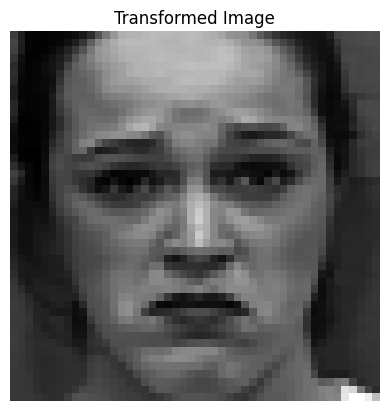

In [51]:
from PIL import Image

# load the image
image_path = 'photos/img4.png'
image = Image.open(image_path).convert('L')

# preprocess the image
transform = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.ToTensor(),
])

# apply the transformation to the image
image = transform(image).unsqueeze(0)
image = image.to(device)

# display the transformed image
np_img = image.squeeze().numpy()
plt.imshow(np_img, cmap = 'gray')
plt.title('Transformed Image')
plt.axis('off')
plt.show()

In [52]:
# predict the mood
with torch.no_grad():
    model.eval()
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)
    predicted_mood = emotion_labels[predicted.item()]
    
print(f"The predicted mood is: {predicted_mood}")

The predicted mood is: contempt


### Difference between the CNN model's performance on the CK+ and FER2013 dataset

* **Dataset complexity and diversity:** The CK* dataset is usually considered less complex and more uniform with clear facial expressions captured in a controlled environment. This makes it easier for the model to learn and generalize well, leading to higher accuracy and performance metrics. In contrast, FER2013 contains images captured in more varied and uncontrolled settings. The images are more diverse in terms of ethnicity, age, and facial positions which makes it a more complex dataset and a more challenging task for the same CNN architecture.

* **Model architecture and capacity:** Although the CNN performed very well on the CK+, its design is limited to a simple dataset and might not be sufficiently robust to handle the intricacies and variations of the FER2013 dataset. This requires a more sophisticated or differently tuned model to address the challenges posed by FER2013. 